<a href="https://colab.research.google.com/github/MtTake/PINNs/blob/main/2D_Navier_Eq_light_bat_f1_1_NavNorm_xlinspc_tanh_difrnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 弾性力学の支配方程式

- つり合い式 \\
- 適合条件式(変位-ひずみ関係式)
- 構成式(応力-ひずみ関係式) \\

### 1. つり合い式
　二次元で考えると、

$$
\frac{\partial \sigma_x}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + X = 0, \\
\frac{\partial \sigma_y}{\partial y} + \frac{\partial \tau_{xy}}{\partial x} + Y = 0 \\
 $$

### 2. 適合条件式

$$
\frac{\partial^2 \epsilon_x}{\partial y^2} + \frac{\partial^2 \epsilon_y}{\partial x^2} = \frac{\partial^2 \gamma_{xy}}{\partial x \partial y}, \\
\epsilon_x = \frac{\partial u}{\partial x}, \quad
\epsilon_y = \frac{\partial v}{\partial y}, \quad
\gamma_{xy} = \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}
$$

### 3. 構成式

$$
\begin {Bmatrix}
       \epsilon_x \\
       \epsilon_y \\
       \epsilon_z \\
       \gamma_{xy} \\
       \gamma_{yz} \\
       \gamma_{zx}
\end {Bmatrix}
= \frac{1}{E}
\begin {bmatrix}
       1 & -\nu & -\nu & 0 & 0 & 0 \\
       -\nu & 1 & -\nu & 0 & 0 & 0 \\
       -\nu & -\nu & 1 & 0 & 0 & 0 \\
       0 & 0 & 0 & 2(1+\nu) & 0 & 0\\
       0 & 0 & 0 & 0 & 2(1+\nu) & 0 \\
       0 & 0 & 0 & 0 & 0 & 2(1+\nu)
\end {bmatrix}
\begin {Bmatrix}
       \sigma_x \\
       \sigma_y \\
       \sigma_z \\
       \tau_{xy} \\
       \tau_{yz} \\
       \tau_{zx}
\end {Bmatrix}
$$

# Navier の方程式

$$
G \left(\nabla^2u_i + \frac{1}{1-2\nu}\frac{\partial \epsilon_i}{\partial x_i}
 \right) + X_i = \rho \frac{\partial^2 u_i}{\partial t^2} \quad (i=1,2,3) \\
E=2G(1+\nu)
$$

$E$ : ヤング率($206GPa$)、$G$ :せん断弾性係数($79GPa$)、$\nu$ :ポアソン比($0.3$)、括弧内は鉄の場合．


静的釣合い条件では、時間微分の項はゼロとなり、$i$ を $x,y,z$ で書くと、

$$
G \left( \nabla^2u_x + \frac{1}{1-2\nu}\frac{\partial \epsilon_x}{\partial x}  \right) + F_x = 0, \\
G \left( \nabla^2u_y + \frac{1}{1-2\nu}\frac{\partial \epsilon_y}{\partial y} \right) + F_y = 0, \\
G \left( \nabla^2u_z + \frac{1}{1-2\nu}\frac{\partial \epsilon_y}{\partial z} \right) + F_z = 0
$$


# 損失関数

損失関数は、ニューラルネットワークの出力が連続体方程式を満たすようにする．具体的には、以下のような損失関数を定義：

$$ L_{\text{total}} = L_{\text{PDE}} + L_{\text{BC}} + L_{\text{IC}}. $$

- **PDE損失項** $L_{\text{PDE}}$：ネットワークの出力がPDEを満たすようにする損失．具体的には、次の手順で計算：

  1. ネットワークの出力 $u$、$\epsilon$、$X$ から、PDEに必要な偏微分を計算．
  2. PDEの左辺 $\mathcal{L}$ を計算し、その結果がゼロに近くなるようにする．
  3. 損失として、PDEの残差（$\mathcal{L}(u(x,t))$）の二乗和を使用．

$$
L_{\text{PDE}} = \frac{1}{3N_{\text{PDE}}} \sum_{j=1}^{N_{\text{PDE}}}  \sum_{i}^{x,y,z} \left( G \left(\nabla^2u_{ij} + \frac{1}{1-2\nu}\frac{\partial \epsilon_{ij}}{\partial x_{ij}} \right)
 + X_{ij} \right)^2
$$

- **境界条件損失項** $L_{\text{BC}}$：境界条件を満たすようにする損失

  例えば、$x = 0$ と $x = L$ での境界条件が $u_{BC}(0) = u_L$ と $u_{BC}(L) = u_R$ である場合、次のように計算：

$$
\begin{align}
L_{\text{BC}} &= \frac{1}{N_{\text{BC}}} \sum_{j=1}^{N_{\text{BC}}} \left(u(x_j) - u_{\text{BC}}(x_j) \right)^2 \\
&= \frac{1}{2} \sum_{j=1}^{N_{\text{BC}}} \{ \left( u(x_j=0) - u_{\text{BC}}(x_j=0)\right) + \left( u(x_j=L) - u_{\text{BC}}(x_j=L) \right) \} \\
&= \frac{1}{2} \sum_{j=1}^{N_{\text{BC}}} \{ \left( u(x_j=0) - u_{\text{L}}\right) + \left( u(x_j=L) - u_{\text{R}} \right) \} \\
\end{align}
$$

- **初期条件損失項** $L_{\text{IC}}$：初期条件（例えば、$x=0$ のときの $F_x$ の値）を満たすようにする損失．初期条件損失は次のように書ける：

  $$ L_{\text{IC}} = \frac{1}{N_{\text{IC}}} \sum_{k=1}^{N_{\text{IC}}} \left(F_x(x_k) - F_{x\text{IC}}(x_k) \right)^2, $$

  ここで、$u_{\text{IC}}$ は初期条件に従った値．

# 学習

PINNsのトレーニングは、損失関数 $L_{\text{total}}$ を最小化する．ネットワークの出力がPDE、境界条件、初期条件を満たすように重みが調整される．


### 1. ライブラリ インポート

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(111)

In [ ]:
# GPUが利用可能か確認
if torch.cuda.is_available():
    free_total = 0
    for i in range(torch.cuda.device_count()):

        # GPUメモリの情報を取得
        total_memory = torch.cuda.get_device_properties(i).total_memory
        reserved_memory = torch.cuda.memory_reserved(i)
        allocated_memory = torch.cuda.memory_allocated(i)
        free_memory = total_memory - reserved_memory
        free_total += free_memory

        print(f"GPU memory {i}: {total_memory / (1024 **3):.2f} GB")
        print(f"Reserved memory: {reserved_memory / (1024 **3):.2f} GB")
        print(f"Allocated memory: {allocated_memory / (1024 **3):.2f} GB")
        print(f"Free memory: {free_memory / (1024 **3):.2f} GB")
        print('------------------------------')

    print(f"Free Total memory : {free_total / (1024 **3):.2f} GB")

else:
    print("CUDA is not available")

CUDA is not available


### 2. 入力データの生成

In [ ]:
# パラメータ定義
# num_points = 100  # X軸、Y軸の各サンプル数
num_points = 50  # X軸、Y軸の各サンプル数

# N = 100            # 異なるデータセットの数
# batch_size = 10    # バッチサイズ
N = 1               # 異なるデータセットの数
batch_size = 1      # バッチサイズ

size = 1     # [m]　平板サイズ
Fphy = 1     # [N]　入力荷重

n_in_out = 2 * num_points**2   # MLPの入力次元
n_make_out = 6 * num_points**2 # MLPの出力次元

# 物理定数
# E = 206 * 10^9 # [Pa] ヤング率
# G = 79 * 10^9  # [Pa] せん断弾性係数
# nu = 0.3       #      ポアソン比
E = 1          # [Pa] ヤング率
nu = 0.3       #      ポアソン比
G = E / (2*(1+nu))          # [Pa] せん断弾性係数

L = 1.0           # 正規化空間範囲
FX = 1.0          # 正規化荷重
# N_bc = 100        # 境界条件数(片側)
N_bc = 50        # 境界条件数(片側)
# N_ic = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# カスタムデータセットの定義
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# 訓練データの生成 ** 格子状
def generate_data0(num_pnts):
    # x と y の範囲を設定
    # torch.rand(num_points, 2) * 2 - 1
    # [-1, 1]の範囲でサンプルを生成
    x_plot = torch.linspace(-L, L, num_points) # [100]
    y_plot = torch.linspace(-L, L, num_points) # [100]

    # メッシュグリッドを作成
    # X_g は x_plot の値を列方向に繰り返した行列
    # Y_g は y_plot の値を行方向に繰り返した行列
    # X_g=[100, 100],Y_g=[100, 100]
    X_g, Y_g = torch.meshgrid(x_plot, y_plot, indexing='ij')

    # Flatten 行優先で1行目のあとに2行目を並べる
    X_flat = X_g.reshape(-1, 1) # [10000, 1]
    Y_flat = Y_g.reshape(-1, 1) # [10000, 1]

    # cat dim=1 で全組み合わせ (n,2)
    cat_data = torch.cat((X_flat, Y_flat), dim=1)  # [10000, 2]

    # [10000, 2] を [20000, 1] にreshape [x1,y1][x1,y2] ⇒ [x1,y1,x2,y2]
    reshaped_data = cat_data.view(-1)  # [20000]

    # print('x_plot',x_plot[:5])

    return reshaped_data.unsqueeze(0)  # [1, 20000] 0次元目を追加

In [ ]:
# 訓練データの生成 ** 乱数
def generate_data(num_pnts):
    # x と y の範囲を設定
    # torch.rand(num_points, 2) * 2 - 1
    # [-1, 1]の範囲でサンプルを生成
    x_plot = torch.rand(num_pnts) * 2 - 1  # [100]
    y_plot = torch.rand(num_pnts) * 2 - 1  # [100]

    # メッシュグリッドを作成
    # X_g は x_plot の値を列方向に繰り返した行列
    # Y_g は y_plot の値を行方向に繰り返した行列
    # X_g=[100, 100],Y_g=[100, 100]
    X_g, Y_g = torch.meshgrid(x_plot, y_plot, indexing='ij')

    # Flatten 行優先で1行目のあとに2行目を並べる
    X_flat = X_g.reshape(-1, 1) # [10000, 1]
    Y_flat = Y_g.reshape(-1, 1) # [10000, 1]

    # cat dim=1 で全組み合わせ (n,2)
    cat_data = torch.cat((X_flat, Y_flat), dim=1)  # [10000, 2]

    # [10000, 2] を [20000, 1] にreshape [x1,y1][x1,y2] ⇒ [x1,y1,x2,y2]
    reshaped_data = cat_data.view(-1)  # [20000]

    # print('x_plot',x_plot[:5])

    return reshaped_data.unsqueeze(0)  # [1, 20000] 0次元目を追加

In [ ]:
# 訓練データの生成 ** 境界を含む乱数
def generate_data2(num_pnts):
    # x と y の範囲を設定
    # torch.rand(num_points, 2) * 2 - 1
    # [-1, 1]の範囲でサンプルを生成
    # x_plot = torch.rand(num_pnts) * 2 - 1  # [100]
    # y_plot = torch.rand(num_pnts) * 2 - 1  # [100]

    x_plot_np = np.random.choice([0, 1] + list(np.random.uniform(0, 1, num_pnts - 2)), size=num_points) * 2 - 1
    y_plot_np = np.random.choice([0, 1] + list(np.random.uniform(0, 1, num_pnts - 2)), size=num_points) * 2 - 1

    x_plot = torch.tensor(x_plot_np, dtype=torch.float32)
    y_plot = torch.tensor(y_plot_np, dtype=torch.float32)

    # メッシュグリッドを作成
    # X_g は x_plot の値を列方向に繰り返した行列
    # Y_g は y_plot の値を行方向に繰り返した行列
    # X_g=[100, 100],Y_g=[100, 100]
    X_g, Y_g = torch.meshgrid(x_plot, y_plot, indexing='ij')

    # Flatten 行優先で1行目のあとに2行目を並べる
    X_flat = X_g.reshape(-1, 1) # [10000, 1]
    Y_flat = Y_g.reshape(-1, 1) # [10000, 1]

    # cat dim=1 で全組み合わせ (n,2)
    cat_data = torch.cat((X_flat, Y_flat), dim=1)  # [10000, 2]

    # [10000, 2] を [20000, 1] にreshape [x1,y1][x1,y2] ⇒ [x1,y1,x2,y2]
    reshaped_data = cat_data.view(-1)  # [20000]

    # print('x_plot',x_plot[:5])

    return reshaped_data.unsqueeze(0)  # [1, 20000] 0次元目を追加

In [ ]:
# 学習用のサンプルデータの生成
all_data = [generate_data0(num_points) for _ in range(N)]

# データを結合し、[N, 20000]の形状に変換
combined_data = torch.cat(all_data)  # [N, 20000]
print('combined data = ', combined_data.shape)

# カスタムデータセットを作成
dataset = CustomDataset(combined_data)

# DataLoaderの作成
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

combined data =  torch.Size([1, 5000])


x : tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
y : tensor([-1.0000, -0.9592, -0.9184, -0.8776, -0.8367, -0.7959, -0.7551, -0.7143,
        -0.6735, -0.6327])


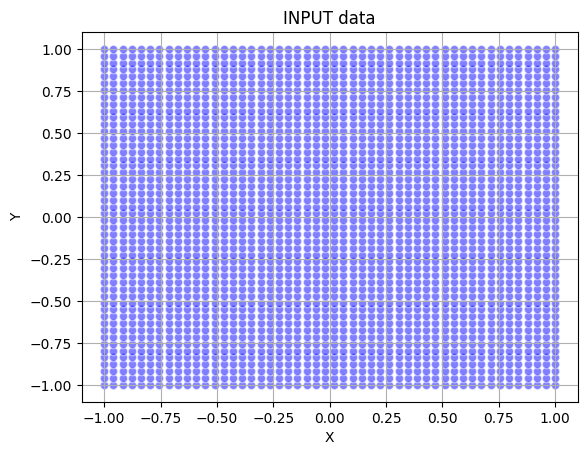

In [ ]:
# サンプルデータの確認

test_data = generate_data0(num_points)
test_data_xy = test_data.reshape(-1, num_points**2, 2)   # 配列の分離(N, n, 2)
test_data_x = test_data_xy[:, :, 0].reshape(-1, num_points**2).flatten()
test_data_y = test_data_xy[:, :, 1].reshape(-1, num_points**2).flatten()

# print("xy shape:", test_data_xy.shape)
# print("x shape:", test_data_x.shape)
# print("y shape:", test_data_y.shape)
print("x :", test_data_x[:10])
print("y :", test_data_y[:10])

# 散布図の作成
plt.scatter(test_data_x, test_data_y, c='blue', alpha=0.5, edgecolors='w')

# 軸ラベルとタイトルの設定
plt.xlabel('X')
plt.ylabel('Y')
plt.title('INPUT data')

# グリッドの表示
plt.grid(True)

# プロットの表示
plt.show()


### 3. ネットワークモデルの定義

In [ ]:
# ニューラルネットワークの定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(n_in_out, 512)
        self.fc2 = nn.Linear(512, 512)
        # self.bn2 = nn.BatchNorm1d(2048)
        # self.fc3 = nn.Linear(2048, 1024)
        # self.fc4 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(512, n_make_out)
        # self.fc5 = nn.Sigmoid()
        self.fc5 = nn.Tanh()
        self.apply(self.init_weights) # 重み初期化を適用

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)  # Xavier初期化
            if m.bias is not None:
                init.zeros_(m.bias)  # バイアスはゼロ初期化

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        # x = self.bn2(x)
        # x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        # x = F.leaky_relu(self.fc4(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.01)
        x = self.fc5(x)
        return x

### 4. Loss関数の定義

In [ ]:
# Navier方程式の計算
def derivatives(x, u):
    # 入力の順に合わせる　1次元が、{x1,y1,x2,y2,...,xn,yn}
    re_u = u.reshape(-1, num_points**2, 6)   # 配列の6次元を分離(N, n, 6)
    re_ux = re_u[:, :, :2].reshape(-1, 2*num_points**2)    # (N, 2*n)
    re_ex = re_u[:, :, 2:4].reshape(-1, 2*num_points**2)
    re_fx = re_u[:, :, 4:6].reshape(-1, 2*num_points**2)

    # Navier方程式計算
    u_x = torch.autograd.grad(outputs=re_ux, inputs=x, grad_outputs=torch.ones_like(re_ux),
                              create_graph=True, retain_graph=True)[0]
    # grad_outputs=torch.ones_like(u_x[:, 0])を指定するとxの最初の次元に関する勾配を計算
    u_xx = torch.autograd.grad(outputs=u_x[:, 0], inputs=x, grad_outputs=torch.ones_like(u_x[:, 0]),
                                create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(outputs=u_x[:, 1], inputs=x, grad_outputs=torch.ones_like(u_x[:, 1]),
                                create_graph=True, retain_graph=True)[0]
    u_e = torch.autograd.grad(outputs=re_ex, inputs=x, grad_outputs=torch.ones_like(re_ex),
                              create_graph=True, retain_graph=True)[0]

    u_xx = u_xx.reshape(-1, 2)
    u_yy = u_yy.reshape(-1, 2)
    u_e = u_e.reshape(-1, 2)
    u_f = re_fx.reshape(-1, 2)

    return u_xx, u_yy, u_e, u_f

In [ ]:
# 境界条件の損失関数
def bound_loss(model, x_bc, u_bc):
    # 境界条件のデータを作成
    # 境界条件が先頭で、それ以外はランダムデータ
    bc_num = x_bc.size(1)                                   # 2番目の次元のサイズ
    bc_other_num = 2*num_points**2 - bc_num                 # 20000点群から境界点数を引く
    bc_other = generate_data(num_points)[:, :bc_other_num]  # 20000点群作成し、境界点以外の点群数だけ採用
    x_bc_all = torch.cat((x_bc, bc_other), dim=1)           # 境界点群とそれ以外を結合し、20000点群にする
    # print('gen_input data',num_points**2 - bc_num)
    # print('x_bc',x_bc.shape)
    # print('bc_other',bc_other.shape)
    # print('x_bc_all',x_bc_all.shape)

    x_bc_all = x_bc_all.to(device)
    u_bc = u_bc.to(device)

    # 境界条件損失
    bc_pred = model(x_bc_all)                            # MLPを通す

    # 入力x_tの順に合わせる　1次元が、{x1,y1,x2,y2,...,xn,yn}
    bc_pred_re = bc_pred.reshape(-1, num_points**2, 6)   # 配列の6次元を分離(N, n, 6)
    bc_pred_xy = bc_pred_re[:, :, :2].reshape(1, -1)     # (1, N*n*2)
    bc_pred_xy_n = bc_pred_xy[:, :bc_num]

    loss_bc = torch.mean((bc_pred_xy_n - u_bc)**2)

    # print(bc_pred_re.shape)
    # print(bc_pred_xy.shape)
    # print(bc_pred_xy_n.shape)

    return loss_bc

In [ ]:
# 初期条件の損失関数
def init_loss(model, x_ic, f_ic):
    # 初期条件のデータを作成
    # 初期条件が先頭で、それ以外はランダムデータ
    ic_num = x_ic.size(1)                                   # 2番目の次元のサイズ
    ic_other_num = 2*num_points**2 - ic_num
    ic_other = generate_data(num_points)[:, :ic_other_num]
    x_ic_all = torch.cat((x_ic, ic_other), dim=1)

    x_ic_all = x_ic_all.to(device)
    f_ic = f_ic.to(device)

    # 初期条件損失
    ic_pred = model(x_ic_all)                          # MLPを通す

    # 入力x_tの順に合わせる　1次元が、{x1,y1,x2,y2,...,xn,yn}
    ic_pred_re = ic_pred.reshape(-1, num_points**2, 6)   # 配列の6次元を分離(N, n, 6)
    ic_pred_xy = ic_pred_re[:, :, 4:6].reshape(1, -1)     # (1, N*n*2)
    ic_pred_xy_n = ic_pred_xy[:, :ic_num]

    loss_ic = torch.mean((ic_pred_xy_n - f_ic)**2)

    # print('x_ic',x_ic.shape)
    # print('f_ic',f_ic.shape)
    # print(ic_pred_xy_n.shape)
    # print(ic_pred_xy_n)

    return loss_ic

### 5. モデルの学習

In [ ]:
# ハイパーパラメータ
num_epochs = 1000
# num_epochs = 20000
# learning_rate = 0.001
learning_rate = 0.0001

# モデルの初期化
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# ***** test *******************************************************************
cnt_t = 0
model.eval().to(device)

for x_t in data_loader:
    x_t = x_t.to(device)
    x_t.requires_grad = True                 # 勾配計算を可能にする

    # モデルの出力を計算
    u_t = model(x_t)  # [batch_size=N, 20000] ⇒ [N, 60000]

    # 入力x_tの順に合わせる　1次元が、{x1,y1,x2,y2,...,xn,yn}
    re_u_t = u_t.reshape(-1, num_points**2, 6)   # 配列の6次元を分離(N, n, 6)
    re_ux_t = re_u_t[:, :, :2].reshape(-1, 2*num_points**2)    # (N, 2*n)
    re_ex_t = re_u_t[:, :, 2:4].reshape(-1, 2*num_points**2)
    re_fx_t = re_u_t[:, :, 4:6].reshape(-1, 2*num_points**2)

    # Navier方程式計算
    u_x_t = torch.autograd.grad(outputs=re_ux_t, inputs=x_t, grad_outputs=torch.ones_like(re_ux_t),
                              create_graph=True, retain_graph=True)[0]
    u_xx_t = torch.autograd.grad(outputs=u_x_t, inputs=x_t, grad_outputs=torch.ones_like(u_x_t),
                                create_graph=True, retain_graph=True)[0]
    u_e_t = torch.autograd.grad(outputs=re_ex_t, inputs=x_t, grad_outputs=torch.ones_like(re_ex_t),
                              create_graph=True, retain_graph=True)[0]

    u_xx_t = u_xx_t.reshape(-1, 2)
    u_e_t = u_e_t.reshape(-1, 2)
    u_f_t = re_fx_t.reshape(-1, 2)

print(x_t.shape)
# print('x=',x_t[:5,:4])
print(u_t.shape)
# print('u=',u_t[:5, :12])

print('*** Input ***')
print(x_t.shape)
print('x_t=',x_t[:5])

print('*** Output ***')
print(re_ux_t.shape)
print('re_ux=',re_ux_t[:5])
print(re_ex_t.shape)
print('re_ex=',re_ex_t[:5])
print(re_fx_t.shape)
print('re_fx=',re_fx_t[:5])

print('*** Derivatives ***')
print(u_x_t.shape)
print('u_x=',u_x_t[:5])
print(u_xx_t.shape)
print('u_xx=',u_xx_t[:5])
print(u_e_t.shape)
print('u_e=',u_e_t[:5])

print('境界条件')
x_lwr = torch.full((3, 1), -1)
x_upr = torch.full((3, 1), 1)
y_rnd = torch.rand((2*3, 1))

x_0 = torch.cat((x_lwr, x_upr), dim=0)
x_xy = torch.cat((x_0, y_rnd), dim=1)
print(x_xy.view(1, -1))

# 境界条件のデータ生成
x_1 = torch.cat((torch.full((N_bc, 1), -L), torch.full((N_bc, 1), L)), dim=0) # x=-1,x=1の位置の配列
y_rnd = torch.rand(2 * N_bc, 1)                                               # y軸は乱数
x_bc = torch.cat((x_1, y_rnd), dim=1)                                         # 列方向へ結合
x_bc = x_bc.view(1, -1)                                                       # 1行のデータにする
u_bc = torch.zeros((1, 2 * 2 * N_bc), dtype=torch.float32)                    # x=-1,x=1の境界条件の配列 x,yで2倍

# print('x_bc', x_bc.shape)
# print('u_bc', u_bc.shape)
model.eval().to(device)
loss_bc = bound_loss(model, x_bc, u_bc)
print('loss_bc = ', loss_bc)

# 初期条件
print('初期条件')
x_ic = torch.tensor([[0, 0]], dtype=torch.float32)                             # 荷重点を設定
f_ic = torch.tensor([[1, 1]], dtype=torch.float32)                             # 荷重を入れる

loss_ic = init_loss(model, x_ic, f_ic)
print('loss_ic = ', loss_ic)

NameError: name 'model' is not defined

Epoch 0, Total Loss: 1.3166909217834473, Navier Loss: 0.353555291891098, IC Loss: 0.9568839073181152, BC Loss: 0.006251723039895296
Epoch 100, Total Loss: 0.01135668158531189, Navier Loss: 0.0012800426920875907, IC Loss: 0.01005568727850914, BC Loss: 2.095177478622645e-05
Epoch 200, Total Loss: 0.011780807748436928, Navier Loss: 0.0008514439687132835, IC Loss: 0.010918713174760342, BC Loss: 1.0651046068232972e-05
Epoch 300, Total Loss: 0.003982187248766422, Navier Loss: 0.0009139656322076917, IC Loss: 0.0030625273939222097, BC Loss: 5.694315404980443e-06
Epoch 400, Total Loss: 0.0010568993166089058, Navier Loss: 0.0005115641397424042, IC Loss: 0.0005368819693103433, BC Loss: 8.453150257992093e-06
Epoch 500, Total Loss: 0.0005678735324181616, Navier Loss: 0.0004278046253602952, IC Loss: 0.00013016336015425622, BC Loss: 9.905538718157914e-06
Epoch 600, Total Loss: 0.0009433595114387572, Navier Loss: 0.0003048169892281294, IC Loss: 0.0006322002736851573, BC Loss: 6.342248980217846e-06
Epo

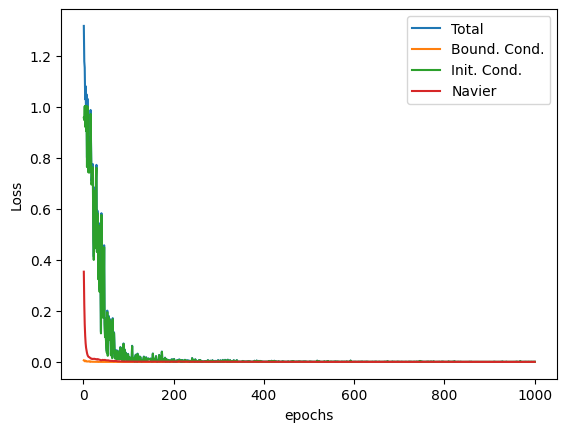

In [ ]:
def clip_log(x):
    # 対数の引数がゼロまたは負でエラー発生するため、下限を設定
    return torch.log(torch.clamp(x, 1e-10, None))

total_error_record = []
nav_error_record = []
bc_error_record = []
ic_error_record = []

# 訓練ループ
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # # 前のエポックで保存したモデルをロード
    # if epoch > 0:
    #     model = torch.load('temp_model.pth')

    model.train()  # トレーニングモード

    # # 前のエポックで使っていた不要なメモリを解放
    # torch.cuda.empty_cache()  #GPUメモリの場合

    loss_total = 0

    for x in data_loader:
        x = x.to(device)
        x.requires_grad = True                 # 勾配計算を可能にする
        # モデルの出力を計算
        u = model(x)  # [batch_size, 20000] ⇒ [batch_size, 60000]

        # Navierの残差を計算
        u_xx, u_yy, u_e, u_f = derivatives(x, u)
        derivatives_residual = G * (size**2 * ((u_xx.sum(dim=1)) + (u_yy.sum(dim=1))) + 1/(1-2*nu)*(u_e.sum(dim=1))) + Fphy * (u_f.sum(dim=1))
        # derivatives_residual = G * (size**2 * (u_xx.sum(dim=1)) + 1/(1-2*nu)*(u_e.sum(dim=1))) + Fphy * (u_f.sum(dim=1))
        # derivatives_residual = (size**2 * (u_xx.sum(dim=1)) + 1/(1-2*nu)*(u_e.sum(dim=1))) + Fphy / G * (u_f.sum(dim=1))

        # 損失を計算 初期値が大のためLOGを取る
        # loss_nav = clip_log(torch.mean(derivatives_residual**2))
        loss_nav = torch.mean(derivatives_residual**2)

        # 境界条件
        x_1 = torch.cat((torch.full((N_bc, 1), -L), torch.full((N_bc, 1), L)), dim=0) # x=-1,x=1の位置の配列
        y_rnd = torch.rand(2 * N_bc, 1)                                               # y軸は乱数
        x_bc = torch.cat((x_1, y_rnd), dim=1)                                         # 列方向へ結合
        x_bc = x_bc.view(1, -1)                                                       # 1行のデータにする
        u_bc = torch.zeros((1, 2 * 2 * N_bc), dtype=torch.float32)                    # x=-1,x=1の境界条件の配列 x,yで2倍

        loss_bc = bound_loss(model, x_bc, u_bc)

        # 初期条件
        x_ic = torch.tensor([[0, 0]], dtype=torch.float32)                             # 荷重点を設定
        f_ic = torch.tensor([[1, 1]], dtype=torch.float32)                             # 荷重を入れる

        loss_ic = init_loss(model, x_ic, f_ic)

        loss = loss_nav + loss_bc + loss_ic

        # 逆伝播と最適化
        loss.backward()
        optimizer.step()

    loss_nav_rec = loss_nav.item()
    loss_bc_rec = loss_bc.item()
    loss_ic_rec = loss_ic.item()
    loss_total = loss.item()
    nav_error_record.append(loss_nav_rec)
    bc_error_record.append(loss_bc_rec)
    ic_error_record.append(loss_ic_rec)
    total_error_record.append(loss_total)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Total Loss: {loss.item()}, Navier Loss: {loss_nav.item()}, IC Loss: {loss_ic.item()}, BC Loss: {loss_bc.item()}')

#     # エポックごとにモデルを保存してメモリを解放
#     torch.save(model, 'temp_model.pth')
#     del model
#     torch.cuda.empty_cache()

# # 最終エポック後、モデルを再ロード
# model = torch.load('temp_model.pth')

###############################################################################
# Loss の推移可視化
import matplotlib.pyplot as plt
plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.plot(range(1, len(bc_error_record)+1),bc_error_record,label="Bound. Cond.")
plt.plot(range(1, len(ic_error_record)+1),ic_error_record,label="Init. Cond.")
plt.plot(range(1, len(nav_error_record)+1),nav_error_record,label="Navier")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()


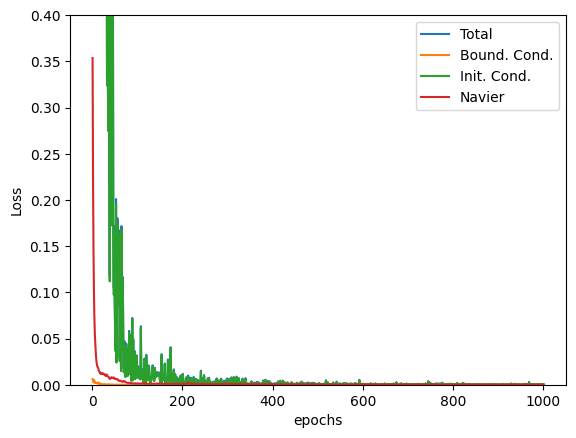

In [ ]:
# Loss の推移可視化
import matplotlib.pyplot as plt

# y軸の範囲を指定
plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.plot(range(1, len(bc_error_record)+1),bc_error_record,label="Bound. Cond.")
plt.plot(range(1, len(ic_error_record)+1),ic_error_record,label="Init. Cond.")
plt.plot(range(1, len(nav_error_record)+1),nav_error_record,label="Navier")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.4) # 最小値と最大値を指定
plt.show()

In [ ]:
# 結果確認
# 境界条件と初期条件のサンプル
model.eval().to(device)

# 境界条件のデータ生成
evx_1 = torch.cat((torch.full((N_bc, 1), -L), torch.full((N_bc, 1), L)), dim=0) # x=-1,x=1の位置の配列
evy_rnd = torch.rand(2 * N_bc, 1)                                               # y軸は乱数
evx_bc = torch.cat((evx_1, evy_rnd), dim=1)                                     # 列方向へ結合
evx_bc = evx_bc.view(1, -1)                                                     # 1行のデータにする
evu_bc = torch.zeros((1, 2 * 2 * N_bc), dtype=torch.float32)                    # x=-1,x=1の境界条件の配列 x,yで2倍

evloss_bc = bound_loss(model, evx_bc, evu_bc)

# 初期条件
evx_ic = torch.tensor([[0, 0]], dtype=torch.float32)                            # 荷重点を設定
evf_ic = torch.tensor([[1, 1]], dtype=torch.float32)                            # 荷重を入れる

evloss_ic = init_loss(model, evx_ic, evf_ic)

print(evx_bc.shape)
print('evx_bc=', evx_bc[0, :10])
print(evu_bc.shape)
print('evu_bc=', evu_bc[0, :10])
print('evx_ic=', evx_ic)
print('evf_ic=', evf_ic)
print('loss_bc=', evloss_bc)
print('loss_ic=', evloss_ic)


torch.Size([1, 200])
evx_bc= tensor([-1.0000,  0.1931, -1.0000,  0.7580, -1.0000,  0.2075, -1.0000,  0.8515,
        -1.0000,  0.1114])
torch.Size([1, 200])
evu_bc= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
evx_ic= tensor([[0., 0.]])
evf_ic= tensor([[1., 1.]])
loss_bc= tensor(1.1065e-05, grad_fn=<MeanBackward0>)
loss_ic= tensor(0.0001, grad_fn=<MeanBackward0>)


# 6. 結果の可視化

torch.Size([50])
X = 0.020408183
Y = 0.020408183
FX= -0.0004788133
FY= -0.00011896765


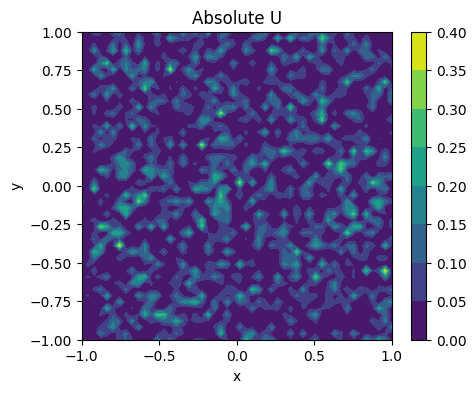

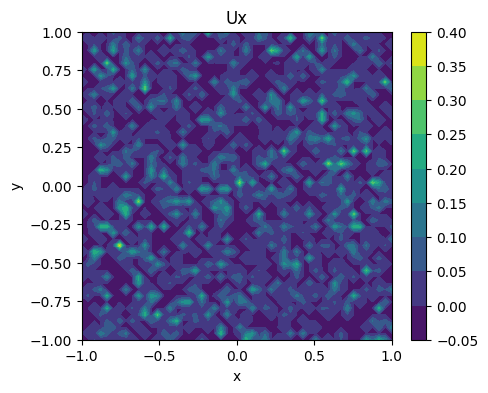

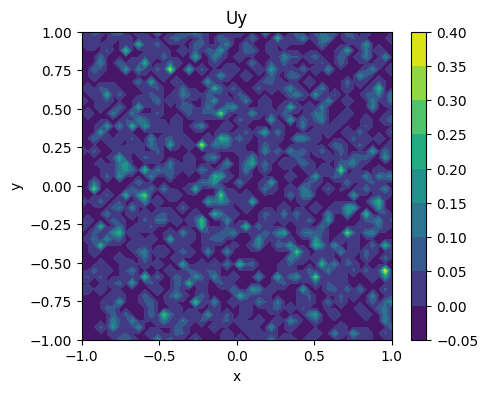

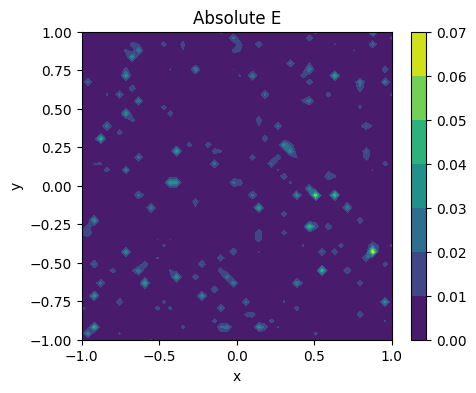

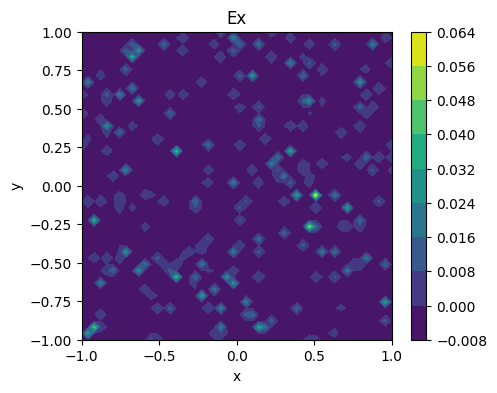

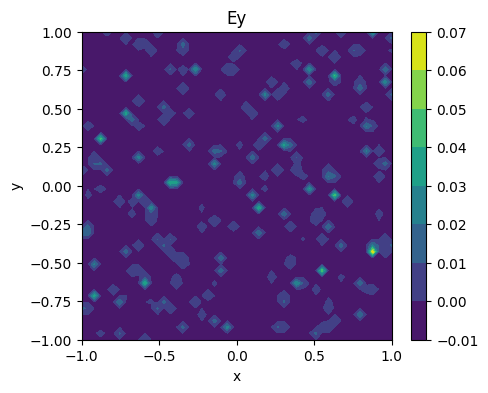

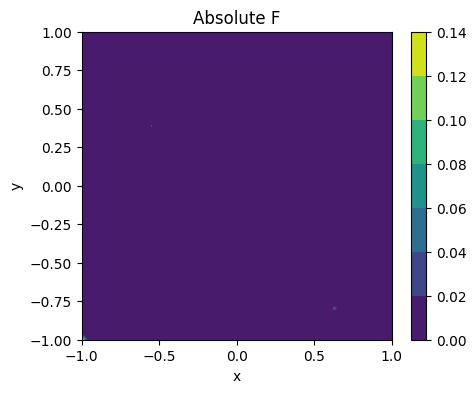

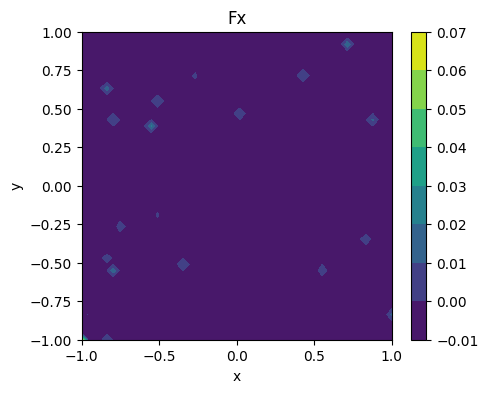

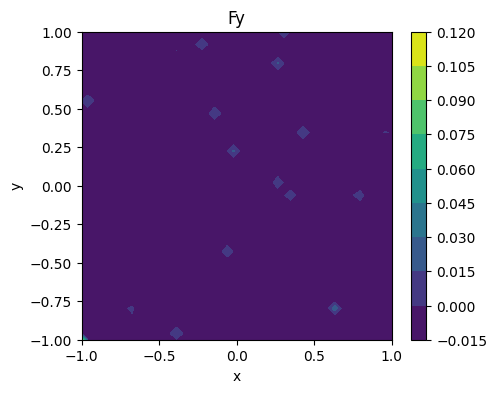

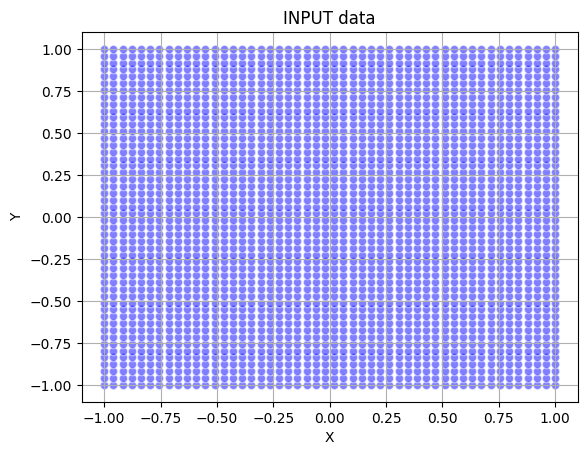

In [ ]:
# 結果の可視化
def plot_solution(net, x):
    with torch.no_grad():
        net.eval().to(device)
        x = x.to(device)

        # ネットワークの出力を計算
        # 全組み合わせ[10000, 2]で、出力[10000, 6]を得る
        u = net(x).cpu().numpy()

        # 入力の順に合わせる　1次元が、{x1,y1,x2,y2,...,xn,yn}
        re_u = u.reshape(-1, num_points**2, 6)   # 配列の6次元を分離(N, n, 6)
        ux = re_u[:, :, 0].reshape(-1, num_points**2)    # (N, n)
        uy = re_u[:, :, 1].reshape(-1, num_points**2)
        ex = re_u[:, :, 2].reshape(-1, num_points**2)
        ey = re_u[:, :, 3].reshape(-1, num_points**2)
        fx = re_u[:, :, 4].reshape(-1, num_points**2)
        fy = re_u[:, :, 5].reshape(-1, num_points**2)

        du = np.sqrt(ux**2 + uy**2)
        de = np.sqrt(ex**2 + ey**2)
        df = np.sqrt(fx**2 + fy**2)

        # x と t を 1D 配列に変換 ⇒ x= (10000,),t= (10000,)
        re_x = x.reshape(-1, 2)
        x_g = re_x[:, 0].cpu().numpy().flatten()
        y_g = re_x[:, 1].cpu().numpy().flatten()

        # メッシュグリッドの生成
        # 再度、[100, 100]にする、x,tをダブり抜きしてからmeshgrid
        # X, Y = np.meshgrid(np.unique(x), np.unique(y))
        X = x_g.reshape(num_points, num_points)
        Y = y_g.reshape(num_points, num_points)

        # u を 2D 配列に変換 [10000, 1]⇒[100, 100]
        UX = ux.reshape(len(np.unique(y_g)), len(np.unique(x_g)))
        UY = uy.reshape(len(np.unique(y_g)), len(np.unique(x_g)))
        DU = du.reshape(len(np.unique(y_g)), len(np.unique(x_g)))
        EX = ex.reshape(len(np.unique(y_g)), len(np.unique(x_g)))
        EY = ey.reshape(len(np.unique(y_g)), len(np.unique(x_g)))
        DE = de.reshape(len(np.unique(y_g)), len(np.unique(x_g)))
        FX = fx.reshape(len(np.unique(y_g)), len(np.unique(x_g)))
        FY = fy.reshape(len(np.unique(y_g)), len(np.unique(x_g)))
        DF = df.reshape(len(np.unique(y_g)), len(np.unique(x_g)))

        # print('X =', X[50,99])
        # print('Y =', Y[50,99])
        # print('FX=', FX[50,99])
        # print('FY=', FY[50,99])
        print('X =', X[25,25])
        print('Y =', Y[25,25])
        print('FX=', FX[25,25])
        print('FY=', FY[25,25])

        # プロット
        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DU, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute U')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, UX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ux')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, UY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Uy')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DE, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute E')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, EX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ex')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, EY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ey')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DF, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute F')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, FX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Fx')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, FY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Fy')
        plt.show()

# 乱数ではなく、格子点で確認
# x と t の範囲を設定
x_plot = torch.linspace(-L, L, num_points) # [100]
y_plot = torch.linspace(-L, L, num_points) # [100]
print(x_plot.shape)
# メッシュグリッドを作成
# X_g は x_plot の値を列方向に繰り返した行列
# Y_g は y_plot の値を行方向に繰り返した行列
# X_g=[100, 100],Y_g=[100, 100]
X_g, Y_g = torch.meshgrid(x_plot, y_plot, indexing='ij')

# Flatten 行優先で1行目のあとに2行目を並べる
X_flat = X_g.reshape(-1, 1) # [10000, 1]
Y_flat = Y_g.reshape(-1, 1) # [10000, 1]

# cat dim=1 で全組み合わせ (n,2)
cat_data = torch.cat((X_flat, Y_flat), dim=1)  # [10000, 2]

# [10000, 2] を [20000, 1] にreshape [x1,y1][x1,y2] ⇒ [x1,y1,x2,y2]
reshaped_data = cat_data.view(-1)  # [20000]

# 結果をプロット
plot_solution(model, reshaped_data.unsqueeze(0))    # [1, 20000] 0次元目を追加

# サンプル点の確認
# 散布図の作成
plt.scatter(X_g, Y_g, c='blue', alpha=0.5, edgecolors='w')

# 軸ラベルとタイトルの設定
plt.xlabel('X')
plt.ylabel('Y')
plt.title('INPUT data')

# グリッドの表示
plt.grid(True)

# プロットの表示
plt.show()

